In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

import pandas as pd

In [2]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/'
                         'treselle-systems/customer_churn_analysis/'
                         'master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn_data = churn_data.set_index('customerID')
churn_data = churn_data.drop(['TotalCharges'], axis=1)

# The dataset is naturally hierarchical: some columns only apply to some users. Ex, if you don't have internet 
# then the column OnlineBackup isn't applicable, as it's value is "No internet service". We 
# are going to map this back to No. We will treat the hierachical nature by stratifying on the 
# different services a user may have. 
churn_data = churn_data.applymap(lambda x: "No" if str(x).startswith("No ") else x)
churn_data['Churn'] = (churn_data['Churn'] == "Yes")
strata_cols = ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']
print(churn_data.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn'],
      dtype='object')


In [4]:
from lifelines import CoxPHFitter

cph = CoxPHFitter().fit(churn_data, 'tenure', 'Churn', 
                        formula="gender + SeniorCitizen + Partner + Dependents  + MultipleLines + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + Contract + PaperlessBilling + PaymentMethod + MonthlyCharges",
                        strata=strata_cols)

In [5]:
cph

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [6]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                   strata = ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -10106.05
         time fit was run = 2020-08-21 13:31:13 UTC

---
                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                        
gender[T.Male]                            -0.09       0.91       0.05            -0.18            -0.00                 0.83                 1.00
Partner[T.Yes]                            -0.53       0.59       0.06            -0.64            -0.42                 0.53                 0.66
Dependents[T.Yes]                         -0.05       0.95       0.07            -0.18             0.09                 0.83                 1.09
MultipleLines[T.Yes]                      -0.44       0.64       0.13            -0.69            -0.19                 0.50                 0.83
OnlineSecurity[T.Yes]                     -0.62       0.54       0.13            -0.88            -0.36                 0.41                 0.70
OnlineBackup[T.Yes]                       -0.65       0.52       0.13            -0.90            -0.40                 0.41                 0.67
DeviceProtection[T.Yes]                   -0.32       0.73       0.13            -0.56            -0.07                 0.57                 0.93
TechSupport[T.Yes]                        -0.40       0.67       0.13            -0.66            -0.14                 0.52                 0.87
Contract[T.One year]                      -1.59       0.20       0.09            -1.77            -1.42                 0.17                 0.24
Contract[T.Two year]                      -3.11       0.04       0.17            -3.45            -2.77                 0.03                 0.06
PaperlessBilling[T.Yes]                    0.19       1.21       0.06             0.08             0.30                 1.08                 1.35
PaymentMethod[T.Credit card (automatic)]  -0.11       0.90       0.09            -0.29             0.07                 0.75                 1.07
PaymentMethod[T.Electronic check]          0.56       1.76       0.07             0.42             0.70                 1.53                 2.02
PaymentMethod[T.Mailed check]              0.51       1.66       0.09             0.33             0.68                 1.39                 1.98
SeniorCitizen                             -0.06       0.94       0.06            -0.17             0.05                 0.84                 1.06
MonthlyCharges                            -0.01       0.99       0.02            -0.05             0.04                 0.95                 1.04
                                              z      p   -log2(p)
covariate                                                        
gender[T.Male]                            -1.98   0.05       4.40
Partner[T.Yes]                            -9.57 <0.005      69.69
Dependents[T.Yes]                         -0.67   0.50       0.99
MultipleLines[T.Yes]                      -3.47 <0.005      10.89
OnlineSecurity[T.Yes]                     -4.65 <0.005      18.20
OnlineBackup[T.Yes]                       -5.09 <0.005      21.39
DeviceProtection[T.Yes]                   -2.51   0.01       6.39
TechSupport[T.Yes]                        -2.99 <0.005       8.49
Contract[T.One year]                     -17.82 <0.005     233.65
Contract[T.Two year]                     -18.00 <0.005     238.16
PaperlessBilling[T.Yes]                    3.29 <0.005       9.97
PaymentMethod[T.Credit card (automatic)]  -1.18   0

<AxesSubplot:xlabel='log(HR) (95% CI)'>

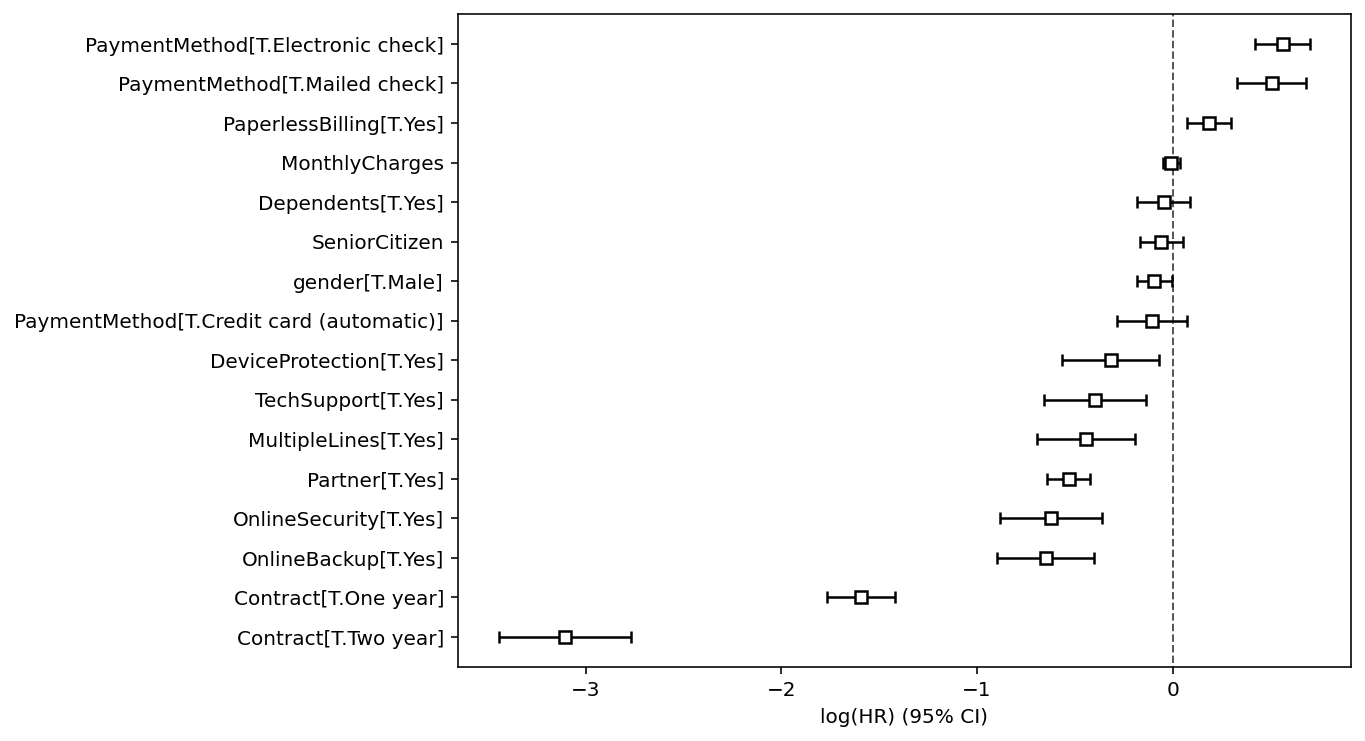

In [7]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

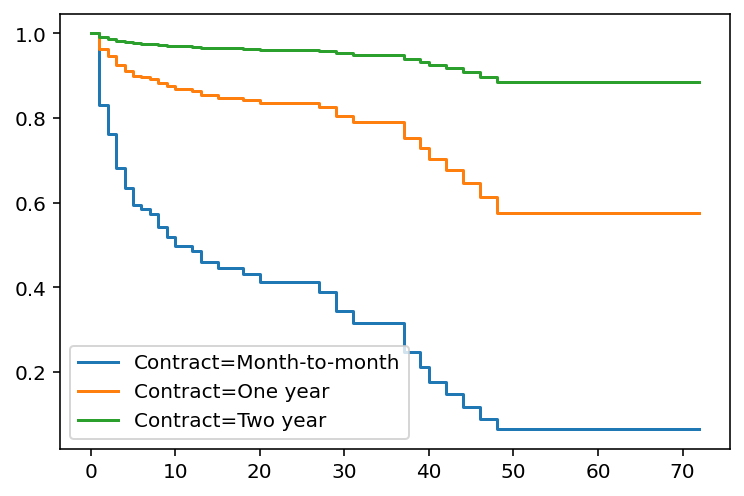

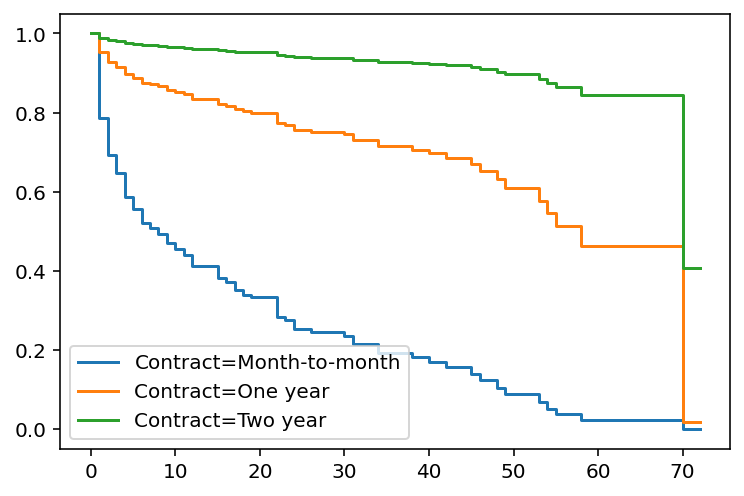

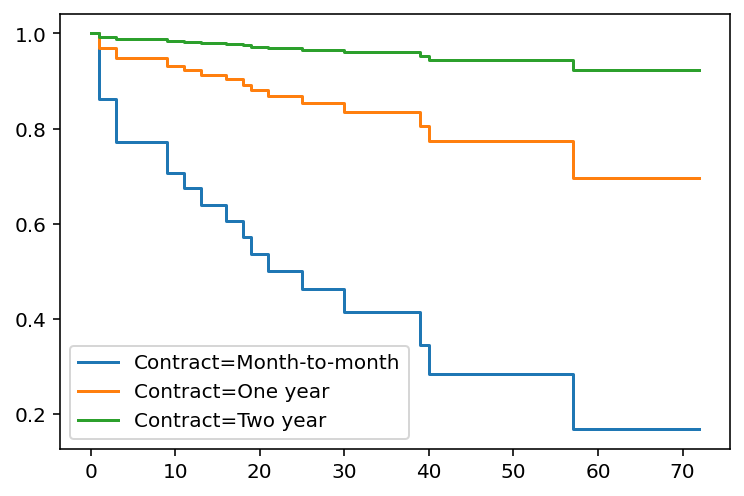

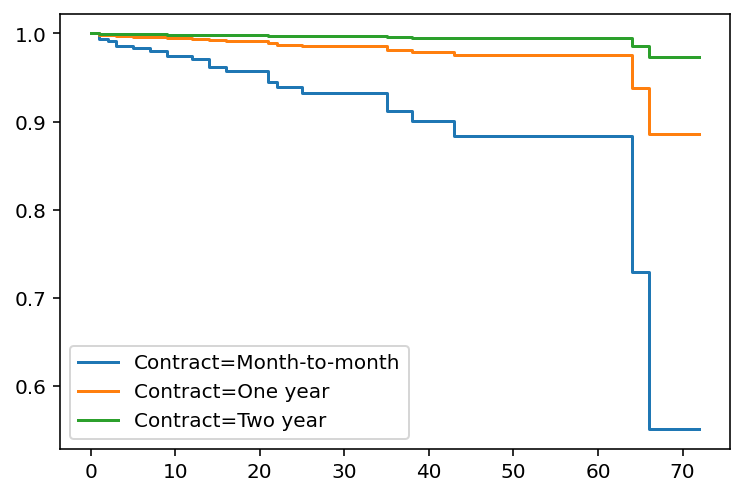

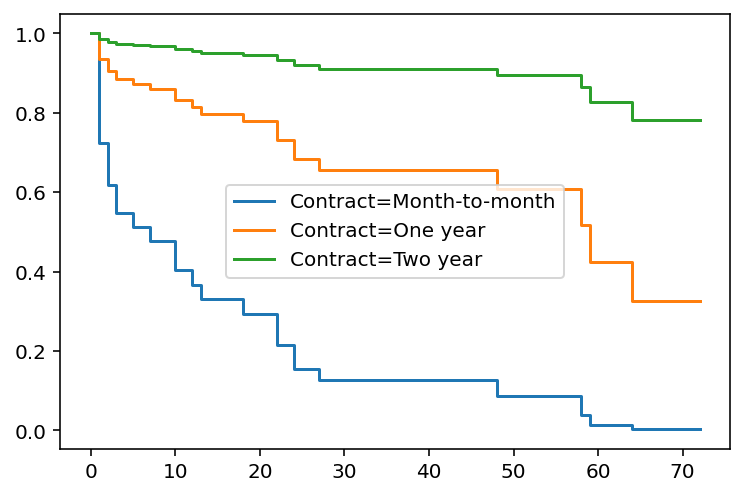

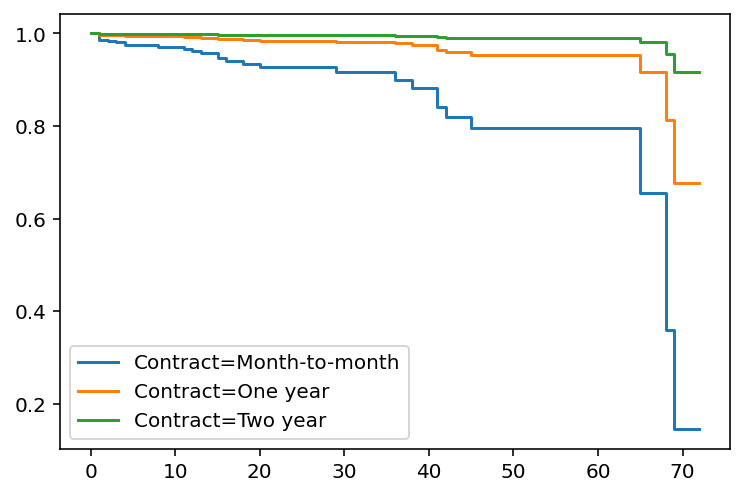

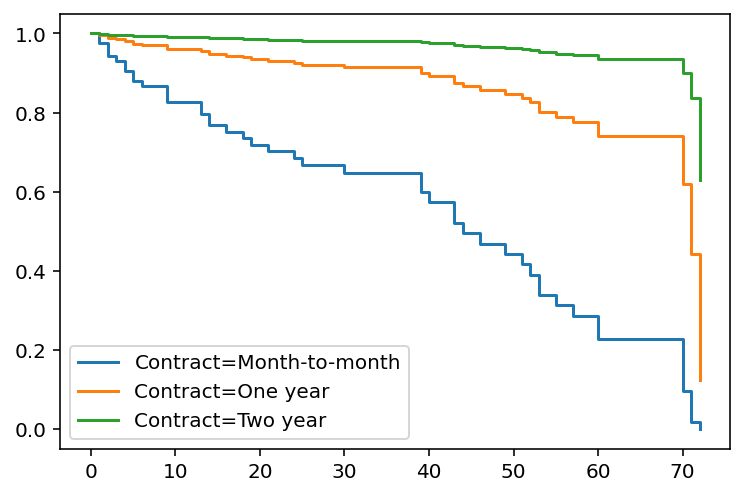

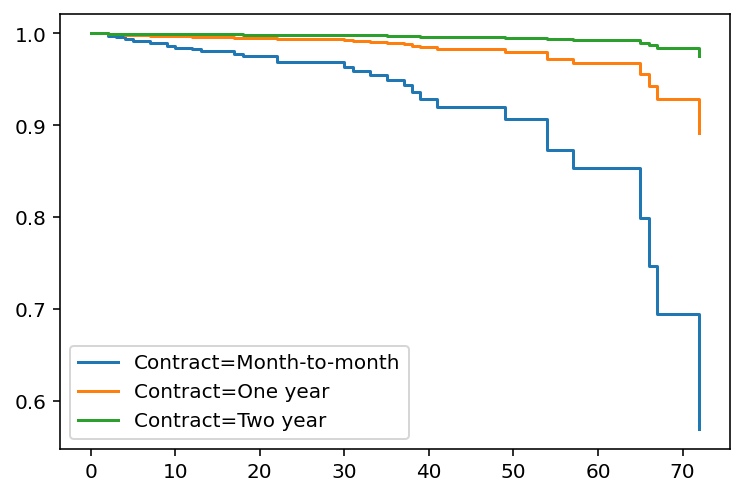

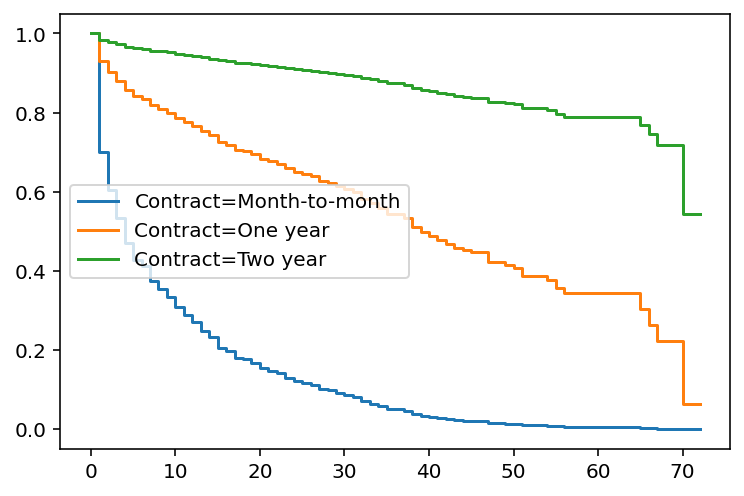

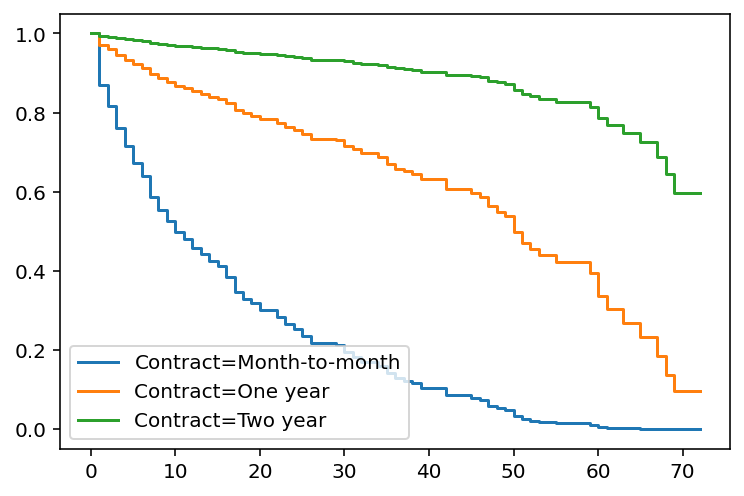

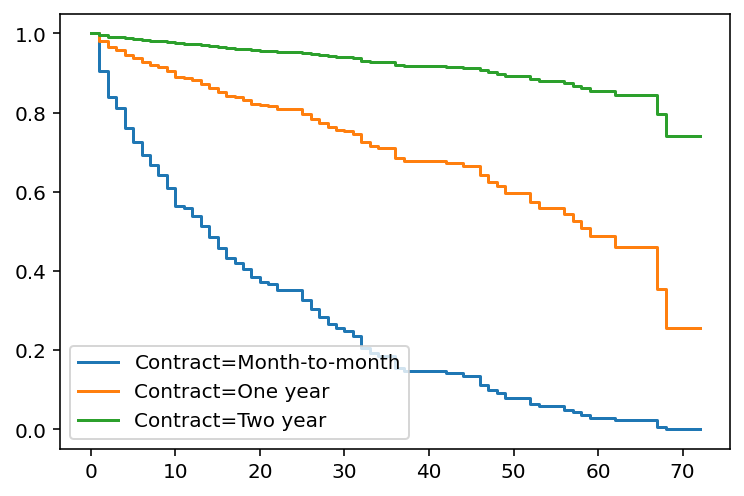

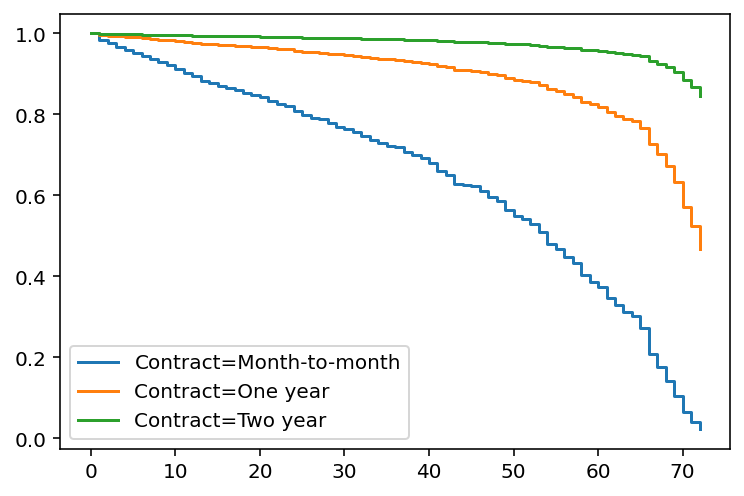

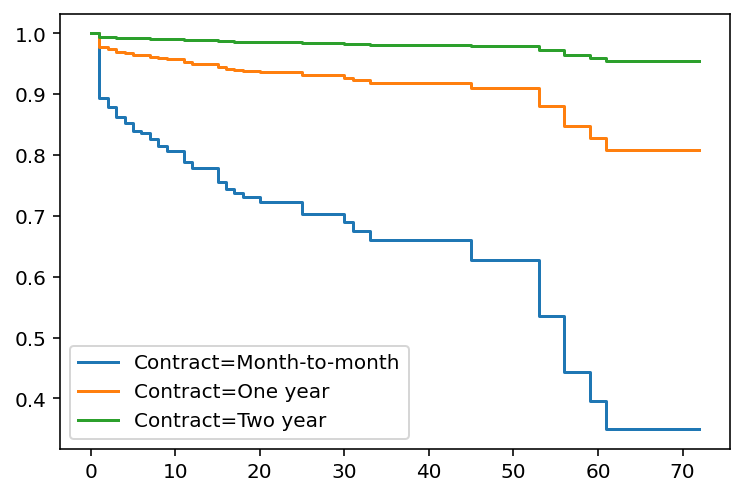

In [8]:
cph.plot_partial_effects_on_outcome('Contract', values=["Month-to-month", "One year", "Two year"], plot_baseline=False);